In [ ]:
!pip install rasterio geopandas statsmodels scikit-learn

# --- Import necessary libraries ---
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import rasterio
from rasterio.transform import rowcol
import geopandas as gpd
import zipfile
from statsmodels.tsa.seasonal import STL
from sklearn.linear_model import LinearRegression
import scipy.signal
from scipy.optimize import curve_fit

# --- Define ENSO Events (will NOT be used) ---
enso_events = [
    {'name': 'El Niño', 'date': pd.Timestamp('2002-11-01'), 'color': '#17becf'},
    {'name': 'La Niña', 'date': pd.Timestamp('2007-12-01'), 'color': '#bcbd22'},
    {'name': 'El Niño', 'date': pd.Timestamp('2009-12-01'), 'color': '#17becf'},
    {'name': 'La Niña', 'date': pd.Timestamp('2010-10-01'), 'color': '#bcbd22'},
    {'name': 'La Niña', 'date': pd.Timestamp('2011-11-01'), 'color': '#bcbd22'},
    {'name': 'El Niño', 'date': pd.Timestamp('2015-12-01'), 'color': '#17becf'},
    {'name': 'La Niña', 'date': pd.Timestamp('2016-11-01'), 'color': '#bcbd22'},
    {'name': 'La Niña', 'date': pd.Timestamp('2020-10-01'), 'color': '#bcbd22'},
    {'name': 'La Niña', 'date': pd.Timestamp('2021-11-01'), 'color': '#bcbd22'},
    {'name': 'La Niña', 'date': pd.Timestamp('2022-10-01'), 'color': '#bcbd22'},
    {'name': 'El Niño', 'date': pd.Timestamp('2023-12-01'), 'color': '#17becf'}
]

# --- Cyclone Events ---
cyclone_events = [
    {'name': 'C00 (Unnamed)', 'date': pd.Timestamp('2000-10-27'), 'color': '#1f77b4'},
    {'name': 'C02 (Unnamed)', 'date': pd.Timestamp('2002-11-12'), 'color': '#ff7f0e'},
    {'name': 'C04 (Unnamed)', 'date': pd.Timestamp('2004-05-15'), 'color': '#2ca02c'},
    {'name': 'C05 (Unnamed)', 'date': pd.Timestamp('2005-10-01'), 'color': '#d62728'},
    {'name': 'C06 (Unnamed)', 'date': pd.Timestamp('2006-06-30'), 'color': '#9467bd'},
    {'name': 'Sidr', 'date': pd.Timestamp('2007-11-15'), 'color': '#8c564b'},
    {'name': 'Nargis', 'date': pd.Timestamp('2008-05-02'), 'color': '#e377c2'},
    {'name': 'Rashmi', 'date': pd.Timestamp('2008-10-26'), 'color': '#7f7f7f'},
    {'name': 'Aila', 'date': pd.Timestamp('2009-05-25'), 'color': '#17becf'},
    {'name': 'Laila', 'date': pd.Timestamp('2010-05-27'), 'color': '#bcbd22'},
    {'name': 'Jal', 'date': pd.Timestamp('2010-11-01'), 'color': '#ff9896'},
    {'name': 'Thane', 'date': pd.Timestamp('2011-12-30'), 'color': '#98df8a'},
    {'name': 'Nilam', 'date': pd.Timestamp('2012-10-30'), 'color': '#ffbb78'},
    {'name': 'Phailin', 'date': pd.Timestamp('2013-10-12'), 'color': '#c5b0d5'},
    {'name': 'Helen', 'date': pd.Timestamp('2013-11-19'), 'color': '#c49c94'},
    {'name': 'Hudhud', 'date': pd.Timestamp('2014-10-12'), 'color': '#f7b6d2'},
    {'name': 'Komen', 'date': pd.Timestamp('2015-07-27'), 'color': '#7f7f7f'},
    {'name': 'Roanu', 'date': pd.Timestamp('2016-05-21'), 'color': '#2ca02c'},
    {'name': 'Vardah', 'date': pd.Timestamp('2016-12-12'), 'color': '#d62728'},
    {'name': 'Mora', 'date': pd.Timestamp('2017-05-30'), 'color': '#9467bd'},
    {'name': 'Ockhi', 'date': pd.Timestamp('2017-12-29'), 'color': '#8c564b'},
    {'name': 'Titli', 'date': pd.Timestamp('2018-10-11'), 'color': '#e377c2'},
    {'name': 'Fani', 'date': pd.Timestamp('2019-05-03'), 'color': '#bcbd22'},
    {'name': 'Bulbul', 'date': pd.Timestamp('2019-11-09'), 'color': '#ff7f0e'},
    {'name': 'Amphan', 'date': pd.Timestamp('2020-05-20'), 'color': '#17becf'},
    {'name': 'Yaas', 'date': pd.Timestamp('2021-05-26'), 'color': '#1f77b4'},
    {'name': 'Jawad', 'date': pd.Timestamp('2021-12-06'), 'color': '#c5b0d5'},
    {'name': 'Asani', 'date': pd.Timestamp('2022-05-11'), 'color': '#ffbb78'},
    {'name': 'Sitrang', 'date': pd.Timestamp('2022-10-24'), 'color': '#7f7f7f'},
    {'name': 'Mandous', 'date': pd.Timestamp('2022-12-06'), 'color': '#ff9896'},
    {'name': 'Mocha', 'date': pd.Timestamp('2023-05-14'), 'color': '#98df8a'},
    {'name': 'Hamoon', 'date': pd.Timestamp('2023-10-24'), 'color': '#d62728'},
    {'name': 'Midhili', 'date': pd.Timestamp('2023-11-17'), 'color': '#9467bd'},
    {'name': 'Remal', 'date': pd.Timestamp('2024-05-26'), 'color': '#8c564b'}
]

# --- Perturbation Detection Function ---
def detect_perturbations(residuals, dates, raw, win_size=24, pct=95, min_drop=0.01):
    residuals_series = pd.Series(residuals, index=dates)
    av_derivative = pd.Series(np.nan, index=dates)
    half_window = win_size // 2

    for i in range(half_window, len(residuals) - half_window):
        av_derivative.iloc[i] = np.nanmean(residuals_series.iloc[i - half_window:i]) - np.nanmean(residuals_series.iloc[i:i + half_window])

    av_derivative = pd.Series(scipy.signal.savgol_filter(av_derivative, 7, 1, deriv=0), index=dates)
    av_derivative_masked = av_derivative.copy()
    av_derivative_masked[av_derivative < np.nanpercentile(av_derivative, pct)] = 0

    transition_indices = scipy.signal.argrelmax(av_derivative_masked.fillna(0).values, order=1)[0]
    transition_dates = dates[transition_indices]

    valid_transitions = []
    for idx in transition_indices:
        local_min_idx = idx + np.argmin(residuals[max(idx, 0):min(idx + 8, len(residuals))])
        drop = raw[idx] - raw[local_min_idx] if idx < len(raw) and local_min_idx < len(raw) else 0
        if drop > min_drop:
            valid_transitions.append((dates[local_min_idx], drop))
    return valid_transitions, av_derivative_masked

# --- Recovery Fitting Function ---
def fit_exp_recovery(residuals, dates, start_date, max_years=5):
    end_date = start_date + pd.Timedelta(days=365.25 * max_years)
    mask = (dates >= start_date) & (dates <= end_date)
    ts = pd.Series(residuals[mask], index=dates[mask]).dropna()

    if len(ts) < 4:
        return None, None, None

    x = np.arange(len(ts))
    y = ts.values
    try:
        popt, _ = curve_fit(lambda t, a, b: a * np.exp(b * t), x, y, p0=(-1, -0.1), bounds=([-np.inf, -np.inf], [0, 0]), maxfev=20000)
        fitted = popt[0] * np.exp(popt[1] * x)
        residuals_fit = y - fitted
        ss_res = np.nansum(residuals_fit**2)
        ss_tot = np.nansum((y - np.nanmean(y))**2)
        rsq = 1 - (ss_res / ss_tot) if ss_tot != 0 else np.nan
        return popt, fitted, rsq
    except:
        return None, None, None

# --- Baseline KNDVI Calculation ---
def calculate_baseline_kndvi(df, start_year=2000, end_year=2000):
    mask = (df['date'].dt.year >= start_year) & (df['date'].dt.year <= end_year)
    kndvi_baseline = df.loc[mask, 'kNDVI']
    mean_kndvi = np.nanmean(kndvi_baseline)
    std_kndvi = np.nanstd(kndvi_baseline)
    status = 'Resilient' if mean_kndvi > 0.49 else 'Moderately resilient' if mean_kndvi > 0.39 else 'Low resilient'
    return mean_kndvi, std_kndvi, status

# --- Region Assignment ---
def assign_region(lon):
    if lon < 89.3:
        return 'West'
    elif lon < 89.6:
        return 'Central'
    else:
        return 'East'

# --- File Paths ---
stack_kndvi_fp = "/content/drive/MyDrive/MODIS_Sundarbans/SRF_kNDVI_2000_2024.tif"
canopy_fp = "/content/drive/MyDrive/MODIS_Sundarbans/SRF_ETH_CanopyHeight_StableLand_2020_250m.tif"
drive_path = "/content/drive/MyDrive/Modis_time_series/"
kmz_path = os.path.join(drive_path, "RSTCSITE_SUNDARBANS.kmz")
sundarbans_fp = "/content/drive/MyDrive/MODIS_Sundarbans/Sundarbans_Shapefile_Export.shp"

# --- Extract Points from KMZ/KML ---
with zipfile.ZipFile(kmz_path, 'r') as kmz:
    kmz.extractall(drive_path)
kml_files = [f for f in os.listdir(drive_path) if f.endswith('.kml')]
if not kml_files:
    raise FileNotFoundError("No KML files found in extracted KMZ.")
kml_file = kml_files[0]
resilience_sites = gpd.read_file(os.path.join(drive_path, kml_file), driver='KML')
kmz_points = [(geom.x, geom.y) for geom in resilience_sites.geometry]

# --- Manual Points ---
manual_points = [
    (89.77, 21.86),
    (89.066211, 21.634621),
    (89.547263, 22.084194),
    (89.3, 22.2),
    (89.73136, 22.029473)
]

# --- Load Raster Data ---
with rasterio.open(stack_kndvi_fp) as src_kndvi:
    stack_kndvi = src_kndvi.read().astype(float)
    transform = src_kndvi.transform
    time_steps = src_kndvi.count
    bounds = src_kndvi.bounds
    crs = src_kndvi.crs

with rasterio.open(canopy_fp) as src_canopy:
    canopy_data = src_canopy.read(1).astype(float)
    canopy_transform = src_canopy.transform
    canopy_bounds = src_canopy.bounds

# --- Generate Date Range ---
dates = pd.date_range('2000-02-18', periods=time_steps, freq='16D')

# --- Function to Extract Time Series for a Point ---
def extract_pixel_time_series(lon, lat):
    if not (bounds.left <= lon <= bounds.right and bounds.bottom <= lat <= bounds.top):
        raise ValueError(f"Point ({lon}, {lat}) outside raster bounds.")
    row, col = rowcol(transform, lon, lat)
    if row < 0 or row >= stack_kndvi.shape[1] or col < 0 or col >= stack_kndvi.shape[2]:
        raise ValueError(f"Point ({lon}, {lat}) outside array bounds.")
    kndvi_ts = stack_kndvi[:, row, col]
    # Get canopy height
    if (canopy_bounds.left <= lon <= canopy_bounds.right and
        canopy_bounds.bottom <= lat <= canopy_bounds.top):
        canopy_row, canopy_col = rowcol(canopy_transform, lon, lat)
        if 0 <= canopy_row < canopy_data.shape[0] and 0 <= canopy_col < canopy_data.shape[1]:
            canopy_height = canopy_data[canopy_row, canopy_col]
        else:
            canopy_height = np.nan
    else:
        canopy_height = np.nan
    df = pd.DataFrame({'date': dates, 'kNDVI': kndvi_ts, 'canopy_height': canopy_height})
    return df

# --- Smoothing Methods ---
def rolling_mean(ts, window=115):
    return pd.Series(ts).rolling(window=window, center=True, min_periods=1).mean().values

def stl_smoothing(ts, period=23, s_window=23, t_window=115):
    stl = STL(ts, period=period, seasonal=s_window, trend=t_window, robust=True)
    res = stl.fit()
    return res.trend, res.seasonal, res.resid

def harmonic_regression(ts, n_harmonics=3, period=23):
    t = np.arange(len(ts))
    X = np.ones((len(ts), 1 + 2 * n_harmonics))
    for k in range(1, n_harmonics + 1):
        X[:, 2*k-1] = np.sin(2 * np.pi * k * t / period)
        X[:, 2*k] = np.cos(2 * np.pi * k * t / period)
    model = LinearRegression().fit(X, ts)
    return model.predict(X)

# --- Calculate Autocorrelation and Variance ---
def calc_ar1(x):
    return np.corrcoef(x[:-1], x[1:])[0,1] if len(x) > 1 and not np.all(np.isnan(x)) else np.nan

def sliding_window_calc(x, win_size):
    ar1 = np.empty(len(x))
    var = np.empty(len(x))
    ar1.fill(np.nan)
    var.fill(np.nan)
    half_win = int(win_size / 2)
    for i in range(half_win, len(x) - half_win):
        subset = x[i - half_win:i + half_win]
        try:
            ar1[i] = calc_ar1(subset)
            var[i] = np.nanvar(subset)
        except:
            ar1[i] = np.nan
            var[i] = np.nan
    return ar1, var

# --- Main Loop over Points ---
first_point_plotted = False
output_dir = "kndvi_analysis_output"
os.makedirs(output_dir, exist_ok=True)

for lon, lat in manual_points:
    print(f"Processing point ({lon:.6f}, {lat:.6f})")
    try:
        df = extract_pixel_time_series(lon, lat)
        print(f"Plotting for point ({lon:.6f}, {lat:.6f})")
        canopy_height = df['canopy_height'].iloc[0]
        region = assign_region(lon)
        baseline_mean, baseline_std, baseline_status = calculate_baseline_kndvi(df)
        kndvi_ts = df['kNDVI'].values
        # Interpolate NaNs if any
        if np.any(np.isnan(kndvi_ts)):
            kndvi_ts = pd.Series(kndvi_ts).interpolate('linear', limit_direction='both').to_numpy()

        # Smooth and decompose
        smoothed_kndvi = rolling_mean(kndvi_ts, window=115)
        trend, seasonal, resid = stl_smoothing(kndvi_ts, period=23, s_window=23, t_window=115)
        detrend = kndvi_ts - smoothed_kndvi
        season = harmonic_regression(detrend, n_harmonics=3, period=23)
        custom_residual = pd.Series(detrend - season, index=df['date'])

        # Detect perturbations
        transitions, av_derivative_masked = detect_perturbations(
            custom_residual.values, df['date'], kndvi_ts, win_size=24, pct=95, min_drop=0.01
        )

        # For each transition, fit recovery and check intersection with cyclones
        recovery_info = []
        for t_date, drop in transitions:
            intersecting_cyclones = [c['name'] for c in cyclone_events if c['date'] >= t_date - pd.Timedelta(days=15) and c['date'] <= t_date + pd.Timedelta(days=15)]
            params, fitted_exp, rsq = fit_exp_recovery(custom_residual.values, df['date'], t_date, max_years=5)
            recovery_info.append({
                'start_date': t_date,
                'drop': drop,
                'fit_rate': params[1] if params is not None else np.nan,
                'rsq': rsq,
                'fitting_dates': df['date'][
                    (df['date'] >= t_date) & (df['date'] <= t_date + pd.Timedelta(days=365.25*5))
                ],
                'fitting_values': custom_residual.values[
                    (df['date'] >= t_date) & (df['date'] <= t_date + pd.Timedelta(days=365.25*5))
                ],
                'fit_curve': fitted_exp,
                'cyclone_impact': intersecting_cyclones
            })

        # Compute autocorrelation and variance
        ar1_custom, var_custom = sliding_window_calc(custom_residual.values, win_size=115)

        # --- Filter cyclones to May-Dec only ---
        may_dec_cyclones = [
            c for c in cyclone_events
            if 5 <= c['date'].month <= 12
        ]

        # --- Filter recovery events to only those with cyclones within ±9 months ---
        filtered_recovery_info = []
        for event in recovery_info:
            t_date = event['start_date']
            matching_cyclones = [
                c for c in may_dec_cyclones
                if abs((c['date'] - t_date).days) <= 270
            ]
            if matching_cyclones:
                event['cyclone_impact'] = [c['name'] for c in matching_cyclones]
                filtered_recovery_info.append(event)
            else:
                event['cyclone_impact'] = []
                filtered_recovery_info.append(event)

        # --- Plotting ---
        fig = plt.figure(figsize=(24, 18))
        gs = fig.add_gridspec(3, 2, height_ratios=[1.2, 1, 1])

        # === SUBPLOT (a): Mean kNDVI Map with Monitoring Points ===
        ax0 = fig.add_subplot(gs[0, 0])
        mean_kndvi = np.nanmean(stack_kndvi, axis=0)
        extent = [bounds.left, bounds.right, bounds.bottom, bounds.top]

        vmin_actual = np.nanmin(mean_kndvi)
        vmax_actual = np.nanmax(mean_kndvi)
        im0 = ax0.imshow(mean_kndvi, cmap='Greens', extent=extent, origin='upper', vmin=vmin_actual, vmax=vmax_actual)

        lons, lats = zip(*manual_points)
        ax0.scatter(lons, lats, color='red', s=60, edgecolor='white', linewidth=1.5, label='Monitoring Points', zorder=5)

        try:
            gdf_boundary = gpd.read_file(sundarbans_fp)
            gdf_boundary.boundary.plot(ax=ax0, color='black', linewidth=1.5, label='Sundarbans Boundary')
        except Exception as e:
            print(f"Warning: Could not load boundary: {e}")

        ax0.set_title('(a) Mean kNDVI (2000–2024) with Monitoring Points', fontsize=13, fontweight='bold')
        ax0.set_xlabel('Longitude', fontsize=14)
        ax0.set_ylabel('Latitude', fontsize=14)
        ax0.tick_params(axis='both', labelsize=14)
        ax0.legend(loc='lower right', fontsize=14, frameon=True, fancybox=True, shadow=True)
        ax0.grid(True, linestyle='--', alpha=0.5)

        cbar = plt.colorbar(im0, ax=ax0, shrink=0.8)
        cbar.set_label(f'Mean kNDVI ({vmin_actual:.3f} to {vmax_actual:.3f})', fontsize=14)
        cbar.ax.tick_params(labelsize=14)

        # === SUBPLOT (b): Time Series ===
        ax1 = fig.add_subplot(gs[0, 1])
        ax1.plot(df['date'], kndvi_ts, label='Raw kNDVI', color='purple', alpha=0.3)
        ax1.plot(df['date'], smoothed_kndvi, label='Rolling Mean', color='blue', linewidth=1.5)
        ax1.plot(df['date'], smoothed_kndvi + seasonal, label='Rolling Mean + Seasonal', color='orange', linewidth=1.5)
        ax1.axhline(baseline_mean, color='black', linestyle='--', label=f'Baseline ({baseline_mean:.2f}) {baseline_status}')
        ax1.set_title(f'(b) kNDVI Time Series\nRegion: {region}, Canopy Height: {canopy_height:.1f}m', fontweight='bold')
        ax1.set_ylabel('kNDVI', fontsize=14)
        ax1.tick_params(axis='both', labelsize=14)
        ax1.legend()
        ax1.grid(True)

        for event in filtered_recovery_info:
            if event['cyclone_impact']:
                for name in event['cyclone_impact']:
                    c_info = next(c for c in may_dec_cyclones if c['name'] == name)
                    ax1.axvline(c_info['date'], color=c_info['color'], linestyle=':', linewidth=2, alpha=0.8)
                    short_name = c_info['name'][:3]
                    ax1.text(c_info['date'], ax1.get_ylim()[1]*0.95, short_name,
                             rotation=90, fontsize=14, color=c_info['color'], ha='center', va='top')

        # === SUBPLOT (c): Residuals and Perturbations ===
        ax3 = fig.add_subplot(gs[1, 0])
        ax3.plot(df['date'], custom_residual, label='Residual', color='blue', linewidth=1.5)
        ax3.plot(df['date'], av_derivative_masked, label='Transition Derivative', color='orange', linestyle='--')
        for t_date, _ in transitions:
            ax3.axvline(t_date, color='red', linestyle='--', alpha=0.7)
        for event in filtered_recovery_info:
            if event['cyclone_impact']:
                for name in event['cyclone_impact']:
                    c_info = next(c for c in may_dec_cyclones if c['name'] == name)
                    ax3.axvline(c_info['date'], color=c_info['color'], linestyle=':', linewidth=2, alpha=0.7)
                    short_name = c_info['name'][:3]
                    ax3.text(c_info['date'], ax3.get_ylim()[1]*0.95, short_name,
                             rotation=90, fontsize=14, color=c_info['color'], ha='center', va='top')
        ax3.set_title('(c) Residuals and Perturbation Detection', fontweight='bold')
        ax3.set_ylabel('Residual', fontsize=14)
        ax3.tick_params(axis='both', labelsize=14)
        ax3.legend()
        ax3.grid(True)

        # === SUBPLOT (d): AC1 ===
        ax4 = fig.add_subplot(gs[1, 1])
        ax4.plot(df['date'], ar1_custom, label='AC1', color='purple')
        for c in may_dec_cyclones:
            ax4.axvline(c['date'], color=c['color'], linestyle=':', alpha=0.7)
            short_name = c['name'][:3]
            ax4.text(c['date'], ax4.get_ylim()[1]*0.95, short_name,
                     rotation=90, fontsize=14, color=c['color'], ha='center', va='top')
        ax4.set_title('(d) Autocorrelation (lag-1)')
        ax4.set_ylabel('AC1', fontsize=14)
        ax4.tick_params(axis='both', labelsize=14)
        ax4.legend()
        ax4.grid(True)

        # === SUBPLOT (e): Variance ===
        ax5 = fig.add_subplot(gs[2, 0])
        ax5.plot(df['date'], var_custom, label='Variance', color='orange')
        for c in may_dec_cyclones:
            ax5.axvline(c['date'], color=c['color'], linestyle=':', alpha=0.7)
            short_name = c['name'][:3]
            ax5.text(c['date'], ax5.get_ylim()[1]*0.95, short_name,
                     rotation=90, fontsize=14, color=c['color'], ha='center', va='top')
        ax5.set_title('(e) Variance', fontweight='bold')
        ax5.set_ylabel('Variance', fontsize=14)
        ax5.tick_params(axis='both', labelsize=14)
        ax5.legend()
        ax5.grid(True)

        # === SUBPLOT (f): Recovery Fits ===
        ax6 = fig.add_subplot(gs[2, 1])
        for event in filtered_recovery_info:
            ax6.plot(event['fitting_dates'], event['fitting_values'], 'b-', alpha=0.7)
            if event['fit_curve'] is not None:
                color = 'red'
                if event['cyclone_impact']:
                    c_name = event['cyclone_impact'][0]
                    c_info = next(c for c in may_dec_cyclones if c['name'] == c_name)
                    color = c_info['color']
                rate = event['fit_rate']
                rsq = event['rsq']
                label_text = f"Recovery (λ={rate:.3f}, R²={rsq:.2f})" if not np.isnan(rate) else f"Recovery (R²={rsq:.2f})"
                ax6.plot(event['fitting_dates'], event['fit_curve'], '--', color=color, linewidth=2, label=label_text)
        for c in may_dec_cyclones:
            short_name = c['name'][:3]
            ax6.axvline(c['date'], color=c['color'], linestyle=':', alpha=0.7)
            ax6.text(c['date'], ax6.get_ylim()[1]*0.95, short_name,
                     rotation=90, fontsize=14, color=c['color'], ha='center', va='top')
        ax6.set_title('(f) Recovery Fits & Cyclone Impacts', fontweight='bold')
        ax6.set_xlabel('Date', fontsize=14)
        ax6.set_ylabel('Residual', fontsize=14)
        ax6.tick_params(axis='both', labelsize=14)
        ax6.legend()
        ax6.grid(True)

        plt.tight_layout()

        # Save figure at 500 DPI
        filename = os.path.join(output_dir, f"kndvi_analysis_{lon:.4f}_{lat:.4f}.png")
        plt.savefig(filename, dpi=500, bbox_inches='tight')
        plt.close()  # Free memory

        if not first_point_plotted:
            first_point_plotted = True

    except Exception as e:
        print(f"Error processing point ({lon}, {lat}): {e}")

Processing point (89.770000, 21.860000)
Plotting for point (89.770000, 21.860000)


/tmp/ipython-input-2195274660.py:315: RuntimeWarning: Mean of empty slice
  mean_kndvi = np.nanmean(stack_kndvi, axis=0)


Processing point (89.066211, 21.634621)
Plotting for point (89.066211, 21.634621)


/tmp/ipython-input-2195274660.py:315: RuntimeWarning: Mean of empty slice
  mean_kndvi = np.nanmean(stack_kndvi, axis=0)


Processing point (89.547263, 22.084194)
Plotting for point (89.547263, 22.084194)


/tmp/ipython-input-2195274660.py:315: RuntimeWarning: Mean of empty slice
  mean_kndvi = np.nanmean(stack_kndvi, axis=0)


Processing point (89.300000, 22.200000)
Plotting for point (89.300000, 22.200000)


/tmp/ipython-input-2195274660.py:315: RuntimeWarning: Mean of empty slice
  mean_kndvi = np.nanmean(stack_kndvi, axis=0)


Processing point (89.731360, 22.029473)
Plotting for point (89.731360, 22.029473)


/tmp/ipython-input-2195274660.py:315: RuntimeWarning: Mean of empty slice
  mean_kndvi = np.nanmean(stack_kndvi, axis=0)


Figure 2

In [ ]:
# Install required packages if not already installed
!pip install rasterio geopandas matplotlib-scalebar cartopy

import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib_scalebar.scalebar import ScaleBar
import geopandas as gpd
import rasterio
from rasterio.mask import mask
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# ------------------------------------------------------------------
# 1. Paths
# ------------------------------------------------------------------
sundarbans_fp = "/content/drive/MyDrive/MODIS_Sundarbans/Sundarbans_Shapefile_Export.shp"
drive_path    = "/content/drive/MyDrive/purturb_resilience_for_baseline2000_2025"
date_suffix   = "20250828_2202HKT_status"

# ------------------------------------------------------------------
# 2. Load shapefile
# ------------------------------------------------------------------
gdf = gpd.read_file(sundarbans_fp)

# ------------------------------------------------------------------
# 3. Image file list & titles (ONLY FIRST 3)
# ------------------------------------------------------------------
image_files = [
    "/content/drive/MyDrive/purturb_resilience_for_baseline2000_2025/perturbation_count_intersected_baseline.tif",
    "/content/drive/MyDrive/purturb_resilience_for_baseline2000_2025/disturbance_index_intersected_baseline.tif",
    "/content/drive/MyDrive/purturb_resilience_for_baseline2000_2025/weighted_index_win24_pct95_20250903_dynamic_1Yba_r2_countdrop_2.tif"
]

plot_titles = [
    'a) Perturbation frequency',
    'b) Disturbance Index-AD',
    'c) Weighted Index-WAD'
]

# ------------------------------------------------------------------
# 4. Read first image to get CRS, extent, resolution
# ------------------------------------------------------------------
with rasterio.open(image_files[0]) as src:
    shapes = [geom for geom in gdf.geometry]
    masked_data, masked_transform = mask(src, shapes, crop=True, nodata=np.nan)
    profile = src.profile
    crs = src.crs
    res = src.res
    res_meters = [r * 111139 for r in res]  # Approx meters per degree
    area_per_pixel_km2 = (res_meters[0] * res_meters[1]) / 1e6
    gdf = gdf.to_crs(crs)

# ------------------------------------------------------------------
# 5. Initialise 3×1 figure
# ------------------------------------------------------------------
fig, axs = plt.subplots(3, 1, figsize=(12, 19),
                        subplot_kw={'projection': ccrs.PlateCarree()})

# ------------------------------------------------------------------
# 6. Loop over images
# ------------------------------------------------------------------
for idx, (file_name, title) in enumerate(zip(image_files, plot_titles)):
    with rasterio.open(file_name) as src:
        masked_data, masked_transform = mask(src, shapes, crop=True, nodata=np.nan)
        kndvi_array = masked_data[0]
        plot_extent = [
            masked_transform[2],
            masked_transform[2] + masked_transform[0] * kndvi_array.shape[1],
            masked_transform[5] + masked_transform[4] * kndvi_array.shape[0],
            masked_transform[5]
        ]

        ax = axs.flat[idx]

        # Mask invalid values
        ma_arr = np.ma.masked_invalid(kndvi_array)
        vmin, vmax = ma_arr.min(), ma_arr.max()

        # Plot with turbo colormap
        im = ax.imshow(ma_arr, cmap='turbo', vmin=vmin, vmax=vmax,
                       extent=plot_extent, transform=ccrs.PlateCarree(),
                       interpolation='none', origin='upper')

        # → ✅ VERTICAL COLORBAR on RIGHT
        cbar = plt.colorbar(im, ax=ax, shrink=0.8, aspect=20, pad=0.02, orientation='vertical')
        cbar.ax.tick_params(labelsize=12)
        cbar.set_label('Value', fontsize=12, rotation=90, labelpad=15)

        # Common map cosmetics
        gdf.boundary.plot(ax=ax, color='black', linewidth=0.5)
        gl = ax.gridlines(draw_labels=True, dms=False, x_inline=False, y_inline=False,
                          xlocs=np.arange(np.floor(plot_extent[0]), np.ceil(plot_extent[1]), 0.5),
                          ylocs=np.arange(np.floor(plot_extent[2]), np.ceil(plot_extent[3]), 0.5),
                          color='gray', alpha=0.3, linestyle='--')
        gl.top_labels = False
        gl.right_labels = False
        gl.xlabel_style = {'size': 9}
        gl.ylabel_style = {'size': 9}
        ax.set_title(title, fontsize=14, fontweight='bold')

        # Add scale bar to last subplot
        if idx == 2:
            scalebar = ScaleBar(111139, location='lower right', units='km', scale_loc='bottom', font_properties={'size': 9})
            ax.add_artist(scalebar)

# ------------------------------------------------------------------
# 7. Adjust layout & save
# ------------------------------------------------------------------
plt.tight_layout(h_pad=0.1, rect=[0, 0, 0.92, 1])  # ← Leave right space for colorbars
plt.savefig(os.path.join(drive_path, f'composite_3x1_vertical_colorbar_{date_suffix}.png'),
            dpi=500, bbox_inches='tight')
plt.show()

Fig 3

In [ ]:
# ================================
# 🌟 FINAL 4-PLOT CODE — λ_AC1 ≥ -2.0 🌟
# ================================

# Install packages (run once)
!pip install rasterio matplotlib numpy scipy geopandas shapely

# Mount Google Drive (Colab only)
from google.colab import drive
drive.mount('/content/drive')

# Import everything
import rasterio
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from scipy.stats import linregress
import geopandas as gpd
import os

# ========================
# 📁 DEFINE FILE PATHS
# ========================
lambda_xt_path = "/content/drive/MyDrive/purturb_resilience_for_baseline2000_2025/lambda_ac1_full_20250828_2202HKT_dynamic_1Ybase_rsq05_mwu_composites_theoretical_ar1_var.tif"
lambda_var_path = "/content/drive/MyDrive/purturb_resilience_for_baseline2000_2025/lambda_var_full_20250828_2202HKT_dynamic_1Ybase_rsq05_mwu_composites_theoretical_ar1_var.tif"
sundarbans_fp = "/content/drive/MyDrive/MODIS_Sundarbans/Sundarbans_Shapefile_Export.shp"
output_dir = "/content/drive/MyDrive/purturb_resilience_for_baseline2000_2025"
output_file = os.path.join(output_dir, "fig1_four_plots_lambdaAC1_ge_minus2.png")

# ========================
# 🖼️ LOAD RASTER DATA
# ========================
with rasterio.open(lambda_xt_path) as lambda_xt_ds:
    lambda_xt = lambda_xt_ds.read(1)
    transform = lambda_xt_ds.transform
    bounds = lambda_xt_ds.bounds
    extent = [bounds.left, bounds.right, bounds.bottom, bounds.top]

with rasterio.open(lambda_var_path) as lambda_var_ds:
    lambda_var = lambda_var_ds.read(1)

# ========================
# 🎯 CREATE MASK: λ_AC1 ≥ -2.0
# ========================
threshold = -2.0
mask_ge_minus2 = (lambda_xt >= threshold) & np.isfinite(lambda_xt) & np.isfinite(lambda_var)

# Apply mask → pixels not meeting condition become NaN
lambda_xt_filtered = np.where(mask_ge_minus2, lambda_xt, np.nan)
lambda_var_filtered = np.where(mask_ge_minus2, lambda_var, np.nan)

# Recalculate ratio only where λ_AC1 ≥ -2.0 and valid
ratio_filtered = np.full_like(lambda_xt, np.nan, dtype=np.float32)
valid_ratio = mask_ge_minus2 & (lambda_xt != 0)
ratio_filtered[valid_ratio] = lambda_var[valid_ratio] / lambda_xt[valid_ratio]

# ========================
# 🗺️ LOAD SUNDARBANS
# ========================
sundarbans = gpd.read_file(sundarbans_fp)

# ========================
# 📊 PREPARE DATA FOR REGRESSION — ONLY WHERE λ_AC1 ≥ -2.0
# ========================
ar1_flat = lambda_xt_filtered.flatten()
var_flat = lambda_var_filtered.flatten()

valid_mask = np.isfinite(ar1_flat) & np.isfinite(var_flat)
ar1_valid = ar1_flat[valid_mask]
variance_valid = var_flat[valid_mask]

print(f"🎯 Pixels where λ_AC1 ≥ {threshold}: {np.sum(mask_ge_minus2)}")
print(f"📈 Valid pairs for regression: {len(ar1_valid)}")

# ========================
# 🎨 CREATE 2x2 FIGURE — EXACTLY 4 SUBPLOTS!
# ========================
fig = plt.figure(figsize=(18, 12))
gs = gridspec.GridSpec(2, 2, hspace=0.3, wspace=0.3)  # 👈 Increased wspace to 0.3 for more column spacing

# --- [0,0] λ_AC1 Map ---
ax1 = fig.add_subplot(gs[0, 0])
im1 = ax1.imshow(lambda_xt_filtered, extent=extent, origin='upper', cmap='RdYlBu_r', vmin=-2, vmax=-0.33)
ax1.grid(True, linestyle='--', color='gray', alpha=0.5)
for _, geom in sundarbans.iterrows():
    ax1.plot(*geom.geometry.exterior.xy, color='black', linewidth=1.4, label='Sundarbans' if _ == 0 else "")
ax1.set_title('a) λ_AC1 ≥ -2.0', fontsize=14, fontweight='bold')
ax1.set_xlabel('Longitude')
ax1.set_ylabel('Latitude')
ax1.legend(loc='lower right')

cax1 = ax1.inset_axes([1.02, 0, 0.03, 1], transform=ax1.transAxes)
cbar1 = fig.colorbar(im1, cax=cax1, orientation='vertical')
cbar1.set_label('λ_AC1', rotation=0, labelpad=20)

# --- [0,1] λ_var Map ---
ax2 = fig.add_subplot(gs[0, 1])
im2 = ax2.imshow(lambda_var_filtered, extent=extent, origin='upper', cmap='coolwarm', vmin=-0.55, vmax=-0.093)
ax2.grid(True, linestyle=':', color='lightgray', alpha=0.6)
for _, geom in sundarbans.iterrows():
    ax2.plot(*geom.geometry.exterior.xy, color='black', linewidth=1.4, label='Sundarbans' if _ == 0 else "")
ax2.set_title('b) λ_var', fontsize=14, fontweight='bold')
ax2.set_xlabel('Longitude')
ax2.set_ylabel('Latitude')
ax2.legend(loc='lower right')

cax2 = ax2.inset_axes([1.02, 0, 0.03, 1], transform=ax2.transAxes)
cbar2 = fig.colorbar(im2, cax=cax2, orientation='vertical')
cbar2.set_label('λ_var', rotation=0, labelpad=20)

# --- [1,0] Ratio Map ---
ax3 = fig.add_subplot(gs[1, 0])
im3 = ax3.imshow(ratio_filtered, extent=extent, origin='upper', cmap='Greens', vmin=0.05, vmax=0.74)
ax3.grid(True, linestyle='-.', color='darkgray', alpha=0.7)
for _, geom in sundarbans.iterrows():
    ax3.plot(*geom.geometry.exterior.xy, color='black', linewidth=1.4, label='Sundarbans' if _ == 0 else "")
ax3.set_title('c) Ratio λ_var / λ_AC1', fontsize=14, fontweight='bold')
ax3.set_xlabel('Longitude')
ax3.set_ylabel('Latitude')
ax3.legend(loc='lower right')

cax3 = ax3.inset_axes([1.02, 0, 0.03, 1], transform=ax3.transAxes)
cbar3 = fig.colorbar(im3, cax=cax3, orientation='vertical')
cbar3.set_label('Ratio', rotation=0, labelpad=20)

# --- [1,1] Scatter + Regression — YOUR 4TH PLOT ✅ ---
ax4 = fig.add_subplot(gs[1, 1])

if len(ar1_valid) > 1:
    slope, intercept, r_value, p_value, std_err = linregress(ar1_valid, variance_valid)

    ax4.scatter(ar1_valid, variance_valid, alpha=0.6, color='steelblue', edgecolor='w', s=40, label='Data (λ_AC1≥-2.0)')
    x_vals = np.linspace(np.nanmin(ar1_valid), np.nanmax(ar1_valid), 100)
    y_vals = slope * x_vals + intercept
    ax4.plot(x_vals, y_vals, color='red', linewidth=3, label=f'Regression (R²={r_value**2:.2f})')

    ax4.set_title(f'd) λ_AC1 vs λ_var\nSlope: {slope:.2f}, Intercept: {intercept:.2f}', fontsize=13, fontweight='bold')
else:
    ax4.text(0.5, 0.5, 'No valid data\nfor regression', ha='center', va='center', fontsize=14, color='red')
    ax4.set_title('d) λ_AC1 vs λ_var', fontsize=13, fontweight='bold')

ax4.set_xlabel('λ_AC1')
ax4.set_ylabel('λ_var')
ax4.legend(fontsize=11)
ax4.grid(True, linestyle='--', alpha=0.5)

# 👇👇👇 EXTRA SPACE BETWEEN COLUMNS 👇👇👇
plt.subplots_adjust(wspace=0.3, hspace=0.3)

# Final polish
plt.tight_layout()
plt.savefig(output_file, dpi=300, bbox_inches='tight')
print(f"🎉 Saved your 4-plot figure to: {output_file}")
plt.show()



In [ ]:
output_dir = "/content/drive/MyDrive/MODIS_Sundarbans"

Figure 4 and 5

Mounted at /content/drive

🎨 Generating Figure 2: Classification...
✅ Saved figure to: /content/drive/MyDrive/MODIS_Sundarbans/fig2_classification.png


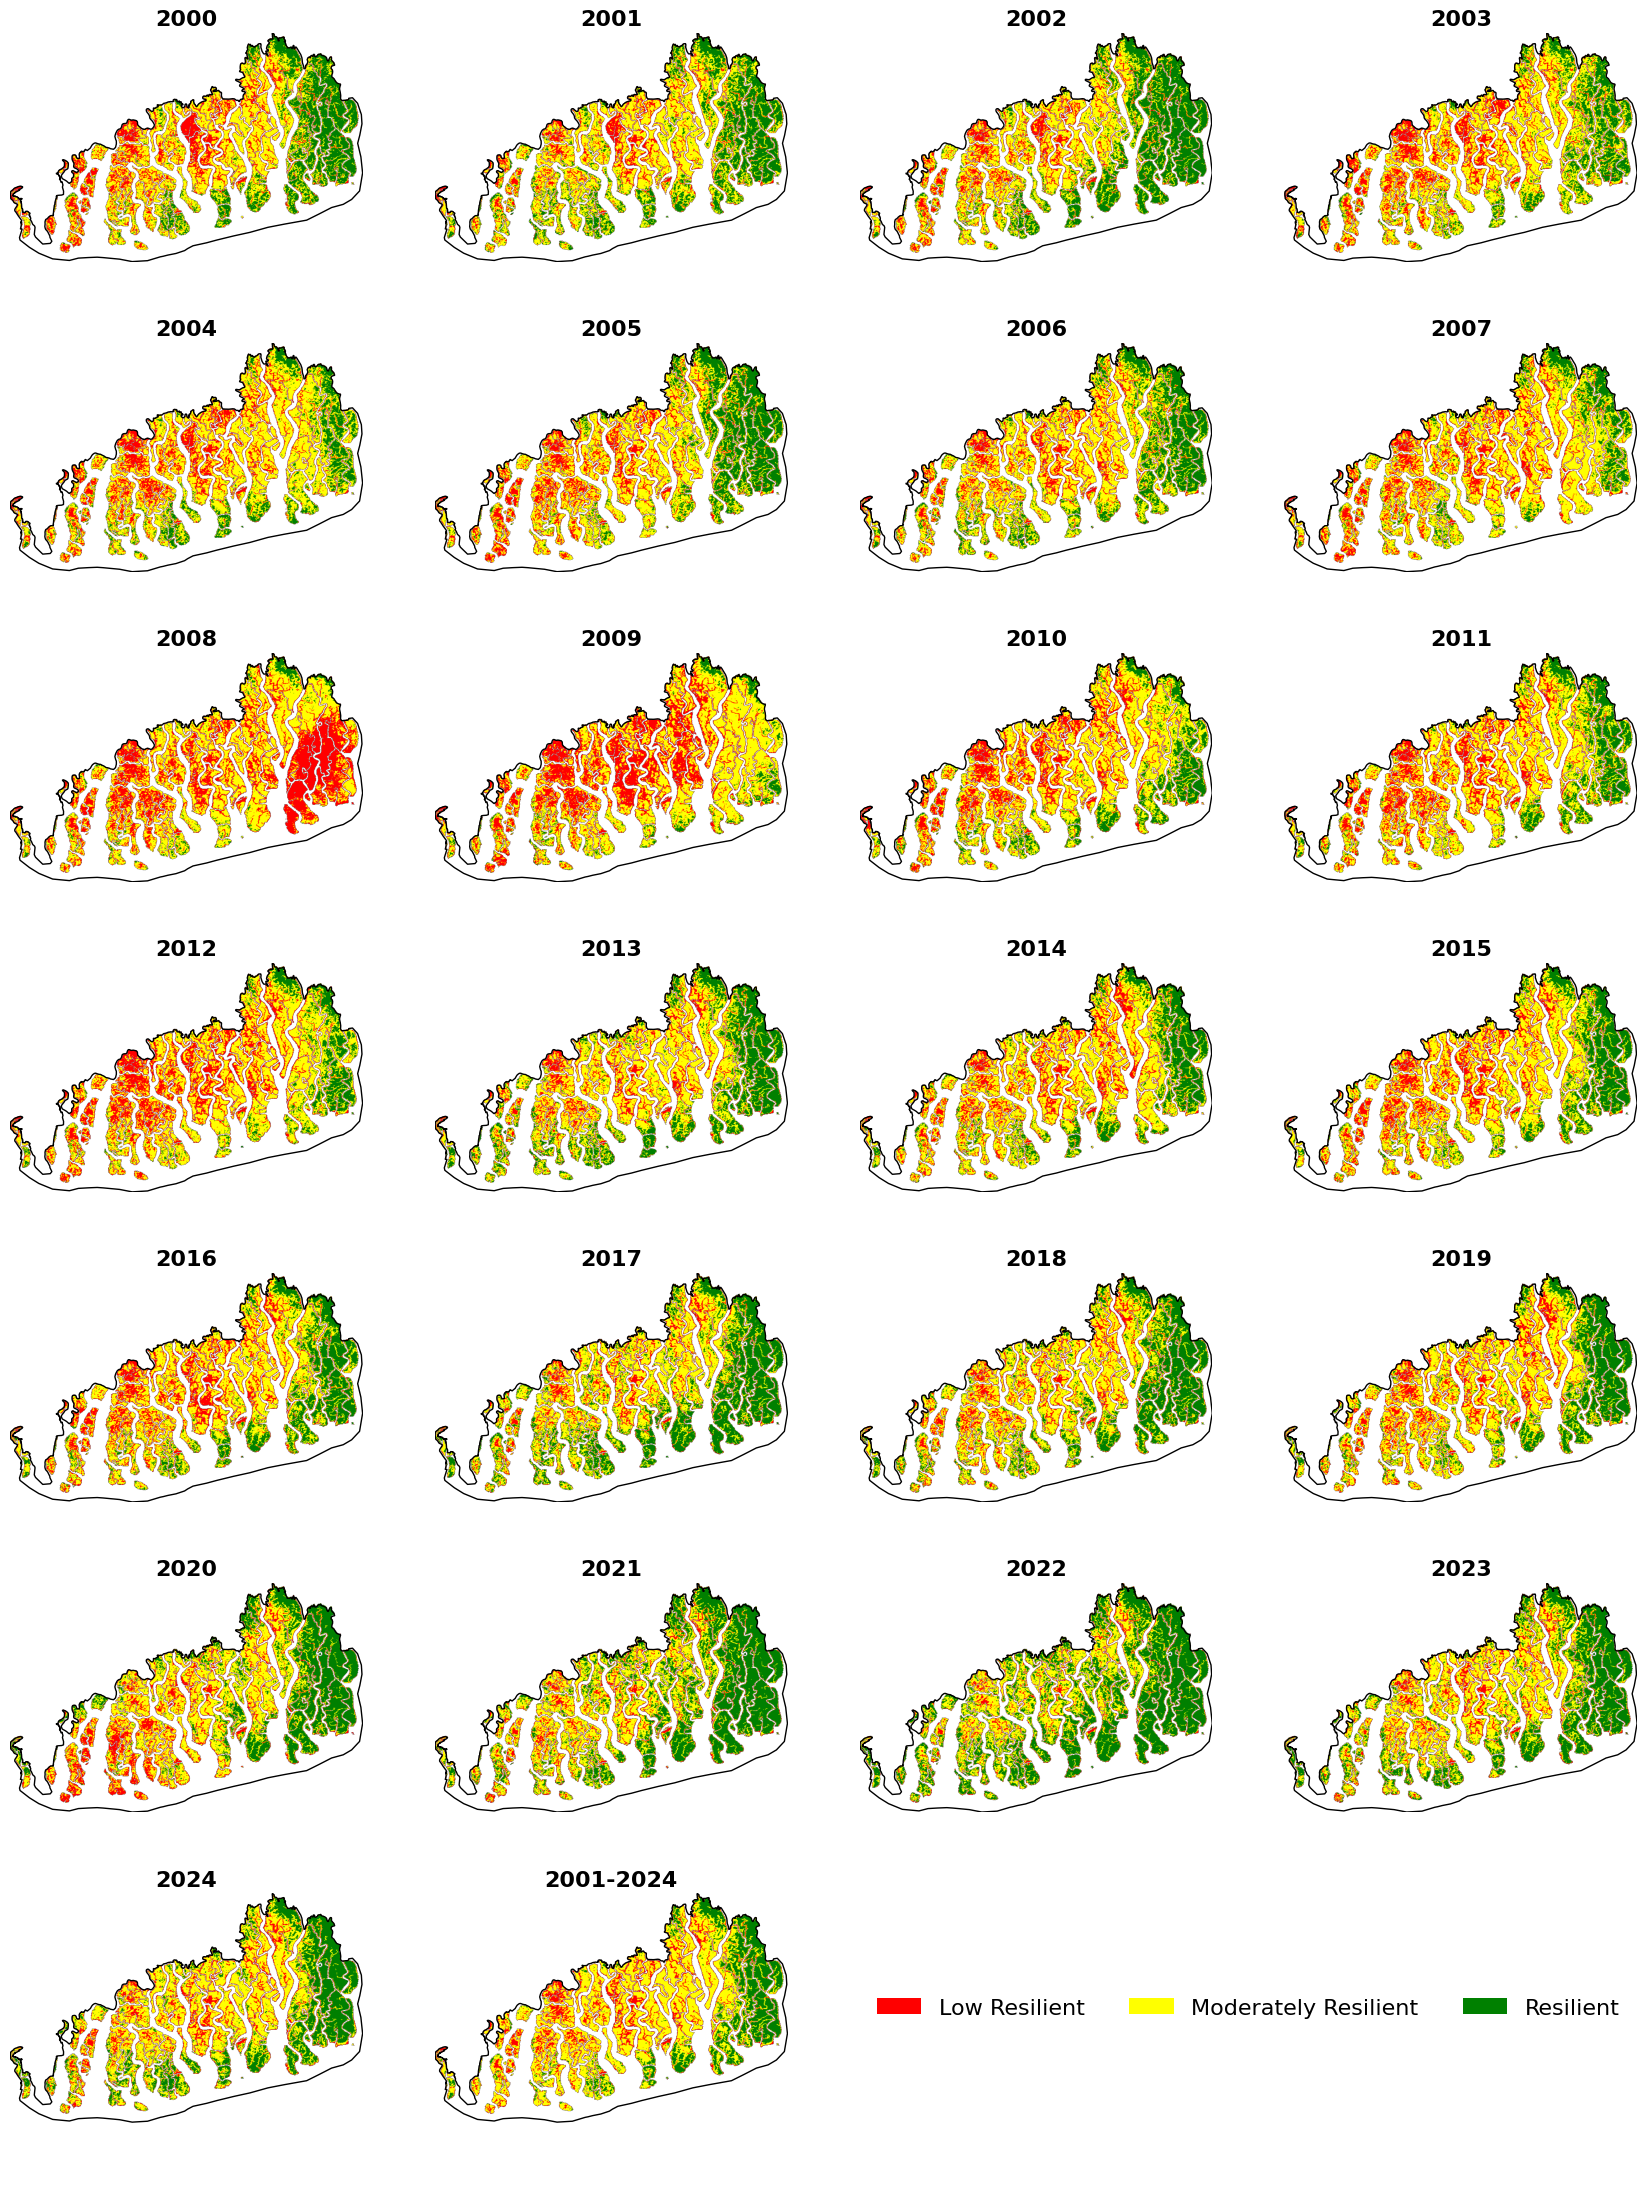


🎨 Generating Figure 3: Resilience Status...
Unique values in Resilience_status_5yrolling_mean02092025.tif: [-3.4e+38  0.0e+00  1.0e+00  2.0e+00]


/usr/local/lib/python3.12/dist-packages/matplotlib/colors.py:777: RuntimeWarning: overflow encountered in multiply
  xa *= self.N


✅ Saved figure to: /content/drive/MyDrive/MODIS_Sundarbans/fig3_resilience_status.png


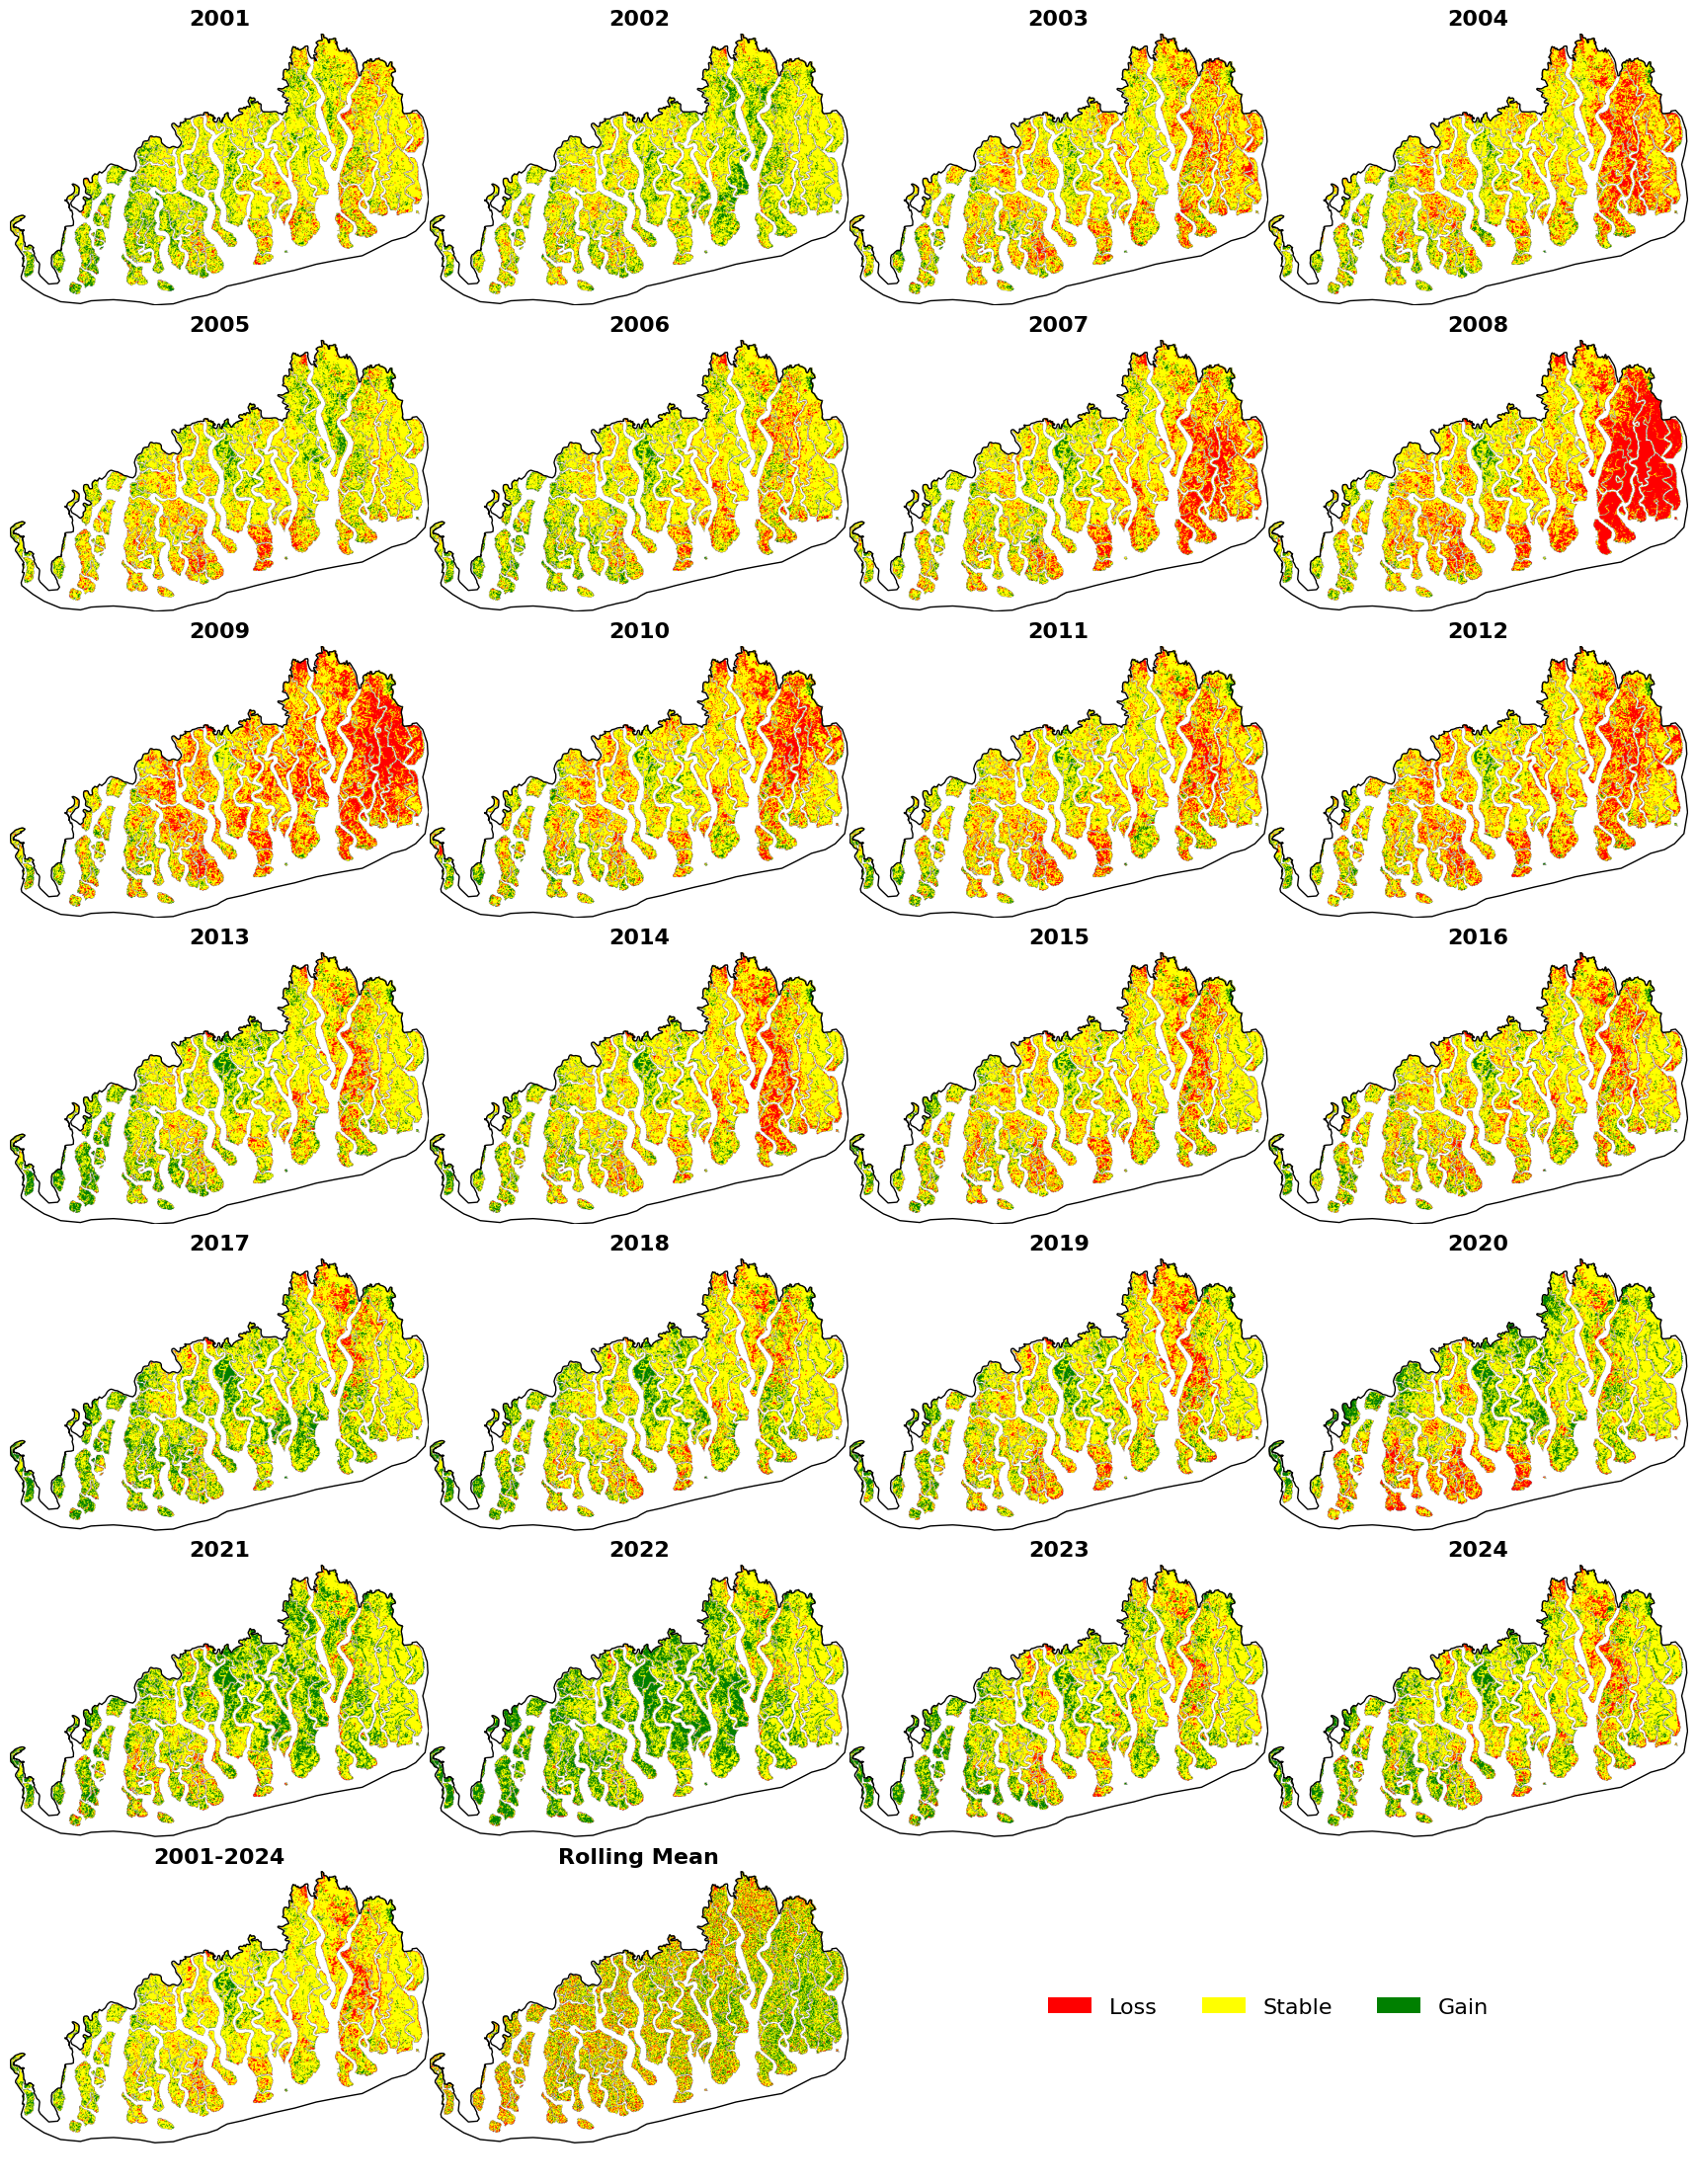


🎉 All figures saved successfully to: /content/drive/MyDrive/MODIS_Sundarbans


In [1]:
# ==============================
# 🌿 COMPLETE FIGURE SAVING CODE 🌿
# ==============================

# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Import necessary libraries
import rasterio
import matplotlib.pyplot as plt
import geopandas as gpd
import numpy as np
import os
from matplotlib.colors import ListedColormap
from matplotlib.patches import Patch

# Define paths
drive_path = "/content/drive/MyDrive/20250906STATUS_resilience_for_baseline2000_2025/annual_composites"
sundarbans_fp = "/content/drive/MyDrive/MODIS_Sundarbans/Sundarbans_Shapefile_Export.shp"
date_suffix = "20250827_base_2000rsq05"
output_dir = "/content/drive/MyDrive/MODIS_Sundarbans"

# Ensure output directory exists
os.makedirs(output_dir, exist_ok=True)

# ------------------------------
# 📊 Plotting Function with Save Option
# ------------------------------
def plot_raster_grid(files, cmap='viridis', figsize=(17, 22), is_categorical=False,
                     vmin=None, vmax=None, nodata_val=None, legend_dict=None, output_path=None):
    num_files = len(files)
    rows, cols = 7, 4
    fig, axs = plt.subplots(rows, cols, figsize=figsize, constrained_layout=False)

    # Load Sundarbans boundary once
    gdf = gpd.read_file(sundarbans_fp)

    im = None  # To store the last image for colorbar

    for i in range(rows * cols):
        row = i // cols
        col = i % cols
        ax = axs[row, col]

        # Reserve bottom-right two cells [6,2] and [6,3] for legend/colorbar
        if row == 6 and col in [2, 3]:
            ax.axis('off')
            continue

        if i < num_files:
            file_path = os.path.join(drive_path, files[i])
            if not os.path.exists(file_path):
                print(f"⚠️ File not found: {file_path}")
                ax.text(0.5, 0.5, "MISSING", ha='center', va='center', fontsize=12, color='red')
                ax.axis('off')
                continue

            with rasterio.open(file_path) as src:
                data = src.read(1)
                current_nodata = -3.4e+38 if '5yrolling_mean02092025' in files[i] else nodata_val

                if '5yrolling_mean02092025' in files[i]:
                    unique_vals = np.unique(data[~np.isnan(data)])
                    print(f"Unique values in {files[i]}: {unique_vals}")

                # Mask no-data and NaN
                if current_nodata is not None:
                    data = np.ma.masked_where((data == current_nodata) | np.isnan(data), data)
                else:
                    data = np.ma.masked_where(np.isnan(data), data)

                extent = [src.bounds.left, src.bounds.right, src.bounds.bottom, src.bounds.top]
                im = ax.imshow(data, cmap=cmap, extent=extent, vmin=vmin, vmax=vmax)

                # --- Title Logic ---
                filename = files[i]
                title = "Unknown"
                if 'average_2001_2024' in filename or 'mean_2001_2024' in filename:
                    title = '2001-2024'
                elif '5yrolling_mean02092025' in filename:
                    title = 'Rolling Mean'
                else:
                    parts = filename.split('_')
                    for part in parts:
                        if part.isdigit() and 2000 <= int(part) <= 2025:
                            title = part
                            break
                ax.set_title(title, fontsize=16, fontweight='bold', y=1.02, pad=2)

                # Overlay Sundarbans boundary
                gdf.boundary.plot(ax=ax, color='black', linewidth=1)
                ax.axis('off')
        else:
            ax.axis('off')  # Hide unused subplots

    # Place legend or colorbar in bottom-right (subplots 27–28)
    if legend_dict:
        legend_ax = fig.add_subplot(7, 4, (27, 28))
        legend_ax.axis('off')
        legend_elements = [Patch(facecolor=color, label=label) for label, color in legend_dict.items()]
        legend_ax.legend(handles=legend_elements, loc='center', ncol=len(legend_dict), fontsize=16, frameon=False)
    else:
        if im is not None:
            cbar_ax = fig.add_subplot(7, 4, (27, 28))
            cbar_ax.axis('off')
            cb = fig.colorbar(im, ax=cbar_ax, orientation='horizontal', pad=0, aspect=40)
            cb.ax.tick_params(labelsize=12)

    # Adjust layout
    plt.subplots_adjust(hspace=0.05, wspace=0.3)
    plt.tight_layout(pad=0.05)

    # ✅ SAVE IF OUTPUT PATH IS GIVEN
    if output_path:
        plt.savefig(output_path, dpi=300, bbox_inches='tight')
        print(f"✅ Saved figure to: {output_path}")

    plt.show()


# ------------------------------
# 🎨 Define Custom Colormaps & Legends
# ------------------------------
class_cmap = ListedColormap(['red', 'yellow', 'green'])  # Low, Moderate, High Resilience
class_legend = {
    'Low Resilient': 'red',
    'Moderately Resilient': 'yellow',
    'Resilient': 'green'
}

status_cmap = ListedColormap(['red', 'yellow', 'green'])  # Loss, Stable, Gain
status_legend = {
    'Loss': 'red',
    'Stable': 'yellow',
    'Gain': 'green'
}




# ------------------------------
# 🖼️ FIGURE 4: Classification (Low / Moderate / Resilient)
# ------------------------------
print("\n🎨 Generating Figure 2: Classification...")
class_files = [f"class_kndvi_year_{year}_{date_suffix}.tif" for year in range(2000, 2025)]
class_files.append(f"class_kndvi_mean_2001_2024_{date_suffix}.tif")
plot_raster_grid(
    class_files,
    cmap=class_cmap,
    is_categorical=True,
    vmin=1,
    vmax=3,
    nodata_val=-1,
    legend_dict=class_legend,
    output_path=os.path.join(output_dir, "fig2_classification.png")
)


# ------------------------------
# 🖼️ FIGURE 5: Resilience Status (Loss / Stable / Gain)
# ------------------------------
print("\n🎨 Generating Figure 3: Resilience Status...")
resilience_files = [f"Resilience_status_year_{year}_{date_suffix}.tif" for year in range(2001, 2025)]
resilience_files.append(f"Resilience_status_mean_2001_2024_{date_suffix}.tif")
resilience_files.append("Resilience_status_5yrolling_mean02092025.tif")
plot_raster_grid(
    resilience_files,
    cmap=status_cmap,
    is_categorical=True,
    vmin=0,
    vmax=2,
    nodata_val=-9999,
    legend_dict=status_legend,
    output_path=os.path.join(output_dir, "fig3_resilience_status.png")
)

print("\n🎉 All figures saved successfully to:", output_dir)